In [11]:
import pickle

file = open('/home/tom/work/rltensor/rltensor/app/ticker1.pkl', 'rb')
tickers = pickle.loads(file.read())
tickers = tickers[1:]
print(tickers)

['USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']


In [12]:
from pytrade_env.database.utils import get_data
import pandas as pd
from copy import deepcopy

start = '2018-06-01 00:00:00'
# end = '2018-09-01 00:00:00'
start = '2016-07-01 00:00:00'
# start = '2018-03-01 00:00:00'
end = '2018-09-01 00:04:00'
dfs = dict()
index = None
tickers = tickers
for ticker in tickers:
    df = get_data(ticker, start, end, period=1800)
    df = df.dropna()
    df_ = df[['high', 'low', 'close', 'open', 'volume']]
    time_idx = pd.DatetimeIndex(df['date'])
    # print(ticker, time_idx)
    df_.index = time_idx
    dfs[ticker] = df_
    if index is None:
        index = df_.index
    else:
        index = index & df_.index
        
for ticker in tickers:
    dfs[ticker] = dfs[ticker].loc[index]
    
tickers.append('CASH')
cash = deepcopy(dfs[tickers[0]])
for col in cash.columns:
    cash[col] = 1.
dfs[tickers[-1]] = cash
    
for ticker in tickers:
    dfs[ticker].to_csv(f'../datasets/crypto/{ticker}.csv')

1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00
1467331201.0 1535760240.0
1467331201.0 1535760240.0
2016-07-01 00:00:00 2018-09-01 00:04:00


In [14]:
import pandas as pd
dfs = dict()
# tickers = tickers[:1]
for ticker in tickers:
    df = pd.read_csv(f'../datasets/crypto/{ticker}.csv')
    df.index = pd.DatetimeIndex(df['date'])
    del df['date']
    dfs[ticker] = df

In [ ]:
%%time
import backtrader as bt

from btbot import get_cerebro
from btbot.strategies import RLStrategy
# from rl_traders.agents import EIIEAgent

cerebro = get_cerebro(startcash=1e10)

for ticker in tickers:
    df = dfs[ticker]
    cols = list(df.columns)
    close_idx = cols.index('close')
    high_idx = cols.index('high')
    low_idx = cols.index('low')
    open_idx = cols.index('open')
    volume_idx =cols.index('volume')
    stock = bt.feeds.PandasData(dataname=df, close=close_idx, high=high_idx,
                                low=low_idx, open=open_idx, volume=volume_idx)
    cerebro.adddata(stock, name=ticker)
    
action_spec = {'shape': len(tickers) + 1, 'type': 'continuous'}

LR_SPEC = {"lr": 3.0e-3, 'name': 'adam'}
SCHEDULER_SPEC = {'name': 'plateau', 'patience': 1000, 'factor': 0.9, 'min_lr': 3.0e-5}
# SCHEDULER_SPEC = {'name': 'step', 'patience': 100, 'factor': 0.5, 'min_lr': 3.0e-5}

EIIE_CONFIG = {
    'lower_params': [{"name": "conv2d", "kernel_size": (3, 1),
                     "in_channels": 3, "out_channels": 2, "stride": 1},
                     # {"name": "batch2d", 'num_features': 2},
                     {"name": "relu"},
                     {"name": "conv2d", "kernel_size": (48, 1),
                      "in_channels": 2, "out_channels": 20, "stride": 1},
                     # {"name": "batch2d", 'num_features': 20},
                     {"name": "relu"},],
    'upper_params': [{"name": "conv2d", "kernel_size": (1, 1),
                     "in_channels": 21, "out_channels": 1, "stride": 1},
                     {"name": "flatten"}],
}


COMMISSION = 2.5e-3
# COMMISSION = 0.0
agent = EIIEAgent(action_spec, model_params=EIIE_CONFIG,
                 memory_limit=100000, window_length=50,
                 batch_size=50, beta=5.0e-5, lr_spec=LR_SPEC, scheduler_spec=SCHEDULER_SPEC,
                 comm_rate=COMMISSION, log_hist_freq=None, is_notebook=True)

warmup = 30000
# warmup = 1000
train_n_epochs = int(2 * 1e6)
# train_n_epochs = 10
cerebro.broker.setcommission(commission=COMMISSION) 
cerebro.addstrategy(RLStrategy, train_freq=1, debug=False,
                    warmup=warmup, agent=agent, train_n_epochs=train_n_epochs, test_n_epochs=30,
                    tickers=tickers, keys=['close', 'high', 'low'])
strategy = cerebro.run()[0]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Delete old tensorboard log


HBox(children=(IntProgress(value=0, max=2000000), HTML(value='')))

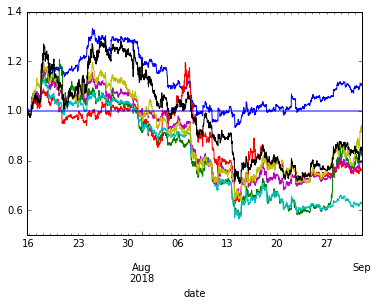

In [26]:
for ticker in tickers:
    value = dfs[ticker]['close'].iloc[30000:]
    value /= value.iloc[0]
    value.plot()

In [50]:
import numpy as np

actions = np.abs(np.random.randn(3, 4))

In [51]:
actions

array([[1.25047601, 1.64430669, 0.47570851, 0.51814082],
       [0.09013829, 0.23487125, 0.85675545, 1.42901053],
       [0.34147422, 0.43183206, 0.63584823, 0.87221521]])

In [52]:
actions /= np.sum(actions, axis=1, keepdims=True)

In [29]:
x = {'a': [3, 4, 5], 'b': [3, 5]}
y = {'a': [3, 5], 'b': [3, 5]}

In [30]:
x == y

False

In [54]:
actions

array([[0.32157221, 0.42284965, 0.12233313, 0.13324501],
       [0.03452548, 0.08996225, 0.32816129, 0.54735098],
       [0.14967947, 0.18928631, 0.27871336, 0.38232085]])

In [9]:
np.random.randn(3, 4) * np.random.randn(3, 1)

array([[-2.67104436, -2.4669553 ,  0.04178035,  0.15638183],
       [-0.04133035, -0.01284285,  0.38425892, -0.79729772],
       [-0.16437249, -0.06762952,  0.04663498,  0.03819769]])

In [10]:
x = torch.randn(3, 4)

In [12]:
x[:, :, None].shape

torch.Size([3, 4, 1])

In [21]:
48 * 365 * 2

35040